In [41]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import animation, colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d

## Helper Function

In [42]:
# random initialization
def rand_weight(x,y,cr,data,seed = 10):

    # x,y - x*y neurons
    # cr - index of cat features start
    # data - input dataframe


    n = data.shape[0]
    p = data.shape[1]

    random.seed(seed)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(random.uniform(0,1))
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = random.uniform(0,1)

                w.append(dic)

            ly.append(w)
            
        l.append(ly)


    
    
    

    return l


# Distance function
def dissimilarity(X, W, cr):

    # X,W - two list with same size

    n = len(X)

    d_num = 0
    d_cat = 0

    for i in range(0,cr):
         d_num += (X[i] - W[i])**2

    for j in range(cr,n):
        d_cat += (1 - W[j][X[j]])**2

    d = d_num + d_cat

    return d




#find the representation of the winner unit chossing highest probability
def cexp(c,cr,n):
    
    c_exp = c[0:cr]

    for i in range(cr,n):
        c_exp.append(max(c[i], key=c[i].get))

    return c_exp



# eucliean distance
def e_distance(x,y):
  return scipy.spatial.distance.euclidean(x,y)



# sigma function
def sigma(s1,s,T):
    sigma = s1*math.exp(-s/T)
    return sigma





# generate intial weight for each neuron
def init_weight(x,y,cr,p,data):

   

    random.seed(1123)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(0)
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = 0

                w.append(dic)

            ly.append(w)
            
        l.append(ly)
    

    return l





#CU##############################################################################

# CU and CV value

def cu(df, cr):
    d = df.shape[0]
    n = df.shape[1] - 3
    tol = 0
    neurons = df.iloc[:,-1].unique()

    for c in neurons:
        n_ci = len(df[df.iloc[:, -1] == c])
        ratio = n_ci / d
        df_ci = df[df.iloc[:, -1] == c]
        
        tol1 = 0
        for i in range(cr,n):
            uniV = df.iloc[:, i].unique()
            uniV_n = len(uniV)
            tol2 = 0
            
            for j in range(uniV_n):
                vij = uniV[j]
                pck = len(df_ci[df_ci.iloc[:, i] == vij]) / n_ci
                p = len(df[df.iloc[:, i] == vij]) / d
                tp = pck**2 - p**2
                
                tol2 += tp
            
            tol1 += tol2
        
        tol += tol1 * ratio
    
    return tol


def var(df,cr):
    d = df.shape[0]
    n = df.shape[1] - 3
    tol = 0
    neurons = df.iloc[:,-1].unique()

    for c in neurons:
        toi = 0
        n_ci = len(df[df.iloc[:, -1] == c])
        df_ci = df[df.iloc[:, -1] == c]
        for i in range(0,cr):
            toj = 0
            Ai = df_ci.iloc[:, i]
            avgAi = np.mean(Ai)
            for j in Ai:
                toj += (j-avgAi)**2
            toi += toj
        tol += (1/n_ci)*toi

    return tol


def cv(df,cr):

    cv = cu(df,cr)/(1+var(df,cr))

    return cv


###################################################################################################
def weightToProt(x,y,cr,W):

    prot = []
    for i in range(x):
        for j in range(y):
            l = []
            w = W[i][j]
            for k in range(0,cr):
                l.append(w[k])
            for h in range(cr,len(w)):
                l.append(max(w[h], key=w[h].get))
            
            prot.append(l)
    return prot



def weightToProt_mat(x,y,cr,W):

    prot = np.empty(shape=(x, y), dtype=object)
    for row in range(x):
        for col in range(y):
            prot[row][col] = [] # empty list to store the label
    for i in range(x):
        for j in range(y):
            
            w = W[i][j]
            for k in range(0,cr):
                prot[i][j].append(w[k])
            for h in range(cr,len(w)):
                prot[i][j].append(max(w[h], key=w[h].get))
            
            
    return prot


########################################################################

def findMax(x,y,Ai,Aj):
  dis = 0
  w = []
  wc = []
  
  indexX = [i for i, a in enumerate(Ai) if a == x]
  indexY = [i for i, a in enumerate(Ai) if a == y]
  
  ajX = [Aj[i] for i in indexX]
  ajY = [Aj[i] for i in indexY]
  
  uniAj = list(set(Aj))
  
  for i in range(len(uniAj)):
    indexU = [j for j, a in enumerate(Aj) if a == uniAj[i]]
    amountX = len([a for a in Ai[indexU] if a == x])
    amountY = len([a for a in Ai[indexU] if a == y])
    
    if len(indexX) == 0:
      pX = 0
    else:
      pX = amountX / len(indexX)
      
    if len(indexY) == 0:
      pY = 0
    else:
      pY = amountY / len(indexY)
    
    if pX >= pY:
      w.append(pX)
      dis += pX
    else:
      wc.append(pY)
      dis += pY
      
  dis -= 1
  
  return dis



def distance(x, y, i, df, cr):
    m, n = df.shape
    tol = 0
    
    for j in range(cr,n):
        if j == i:
            continue
        index_i = df.iloc[:, i]
        index_j = df.iloc[:, j]
        d_ij = findMax(x, y, index_i, index_j)
        tol += d_ij
    
    tol /= (n - 1)
    
    return tol


def sig(Ai, i, df):
    sum_ = 0
    s = pd.unique(Ai)
    m = len(s)
    
    for l in range(m-1):
        for j in range(l+1, m):
            tol = distance(s[l], s[j], i, df,0)
            sum_ += tol
    
    w = sum_ / (m*(m-1)/2)
    
    return w


def sigDf(discdf, cr):
    sigmas = []
  
    if cr != 0:
        for i in range(cr):
            sigmas.append(sig(discdf.iloc[:,i], i, discdf))
            #sigmas.append(1)
    return sigmas



#discretize

def discretize(df, cr):
    m, n = df.shape
    
    mat = np.zeros((m,n))
    discdf = pd.DataFrame(mat)
    
    if cr != 0:
        for i in range(cr):
            discdf[i] = pd.cut(df.iloc[:,i], bins=10, labels=False, retbins=False)
            discdf[i] = discdf[i].astype("category")
            #discdf[i] = df.iloc[:,i].astype("str")
    
    catestart = cr 
    
    if catestart <= n:
        for j in range(catestart, n):
            discdf[j] = df.iloc[:,j]
    
    return discdf



def disBetTwo(d1, d2, cr, df, sigificance):
    length = len(d1)
    vrd1 = d1[0:cr]
    vcd1 = d2[cr:]
    vrd2 = d2[0:cr]
    vcd2 = d2[cr:]
    sumr = 0
    sumc = 0
    
    
    for i in range(0, cr):
        d = (sigificance[i]*(vrd1[i] - vrd2[i]))**2
        sumr += d
    
    for j in range(cr, length):
        d = distance(d1[j], d2[j], j, df,cr)**2
        
        sumc += d
    
    dis = sumr + sumc
    return dis

#-matrix#######################################################################################

def umatix(x,y,w,df,cr):
    # discretize
    sigificance = sigDf(discretize(df,cr), cr)
    print("significance computed")

    mat = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            if (i == 0) and (j == 0):
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/2
                continue
            elif (i == x-1) and (j == 0):
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/2
                continue
            elif (i == 0) and (j == y-1):
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/2
                continue
            elif (i == x-1) and (j == y-1):
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/2
                continue
            elif i == 0:
                mat[i][j] = (disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance) + disBetTwo(w[i+1][j], w[i][j], cr, df, sigificance))/3
                continue
            elif i == x-1:
                mat[i][j] = (disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance) + disBetTwo(w[i-1][j], w[i][j], cr, df, sigificance))/3
                continue
            elif j == 0:
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/3
                continue
            elif j == y-1:
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/3
                continue
            else:
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/4
                continue
    return mat
                


# find BMU
def find_BMU(d1,weight,x,y,cr):
    bmu_x = 0
    bmu_y = 0
    bmu_dist = 10000000000
    for i in range(x):
        for j in range(y):
            d = dissimilarity(d1,weight[i][j],cr)            
            if d < bmu_dist:
                bmu_dist = d
                bmu_x = i 
                bmu_y = j
    return bmu_dist, bmu_x, bmu_y



## Main Model

In [94]:
def train_fmsom(x,
                y,
                data,
                y_label,
                cr,
                s1,
                T,
                nei_fun = None,
                iteration=1000,
                seed = 10):

    # x - x*y neurons
    # y - x*y neurons
    # data - input dataframe
    # cr - number of categorcial attributes
    # s1 - initial radius
    # T - contant for sigma function
    # sigma - radius function
    # dis_fun - distance function
    # nei_fun - neighbourhood function
    # iteration - number of iterations
    # init_weight_fun - initial weight function 


    #MSE
    mse = 0


    #result dataframe
    result = data.copy()
    result['winX'] = 'a'#pd.Series()
    result['winY'] = 'b'#pd.Series()



    # P: sample size
    # F: number of attributes
    P, F = np.shape(data)

    # I: number of neurons
    I = x*y

    accumNeighborhood_i = np.zeros((x,y)) 
    numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)
    
    neuron_jaccard = init_weight(x,y,cr,F,data)


    changed = [False]*P

    #intialize 
    weights = rand_weight(x,y,cr,data,seed)


    ##2d som for visuallization####################################################################
    label_data = y_label
    map = np.empty(shape=(x, y), dtype=object)
    for row in range(x):
        for col in range(y):
            map[row][col] = [] # empty list to store the label
    
    label_map = np.zeros(shape=(x, y),dtype=np.int64)
    dis_map = np.zeros(shape=(x, y),dtype=np.int64)
    ################################################################################################



    for t in range(0,iteration):

        print("current iteration: " + str(t))


        # initialize 2d graph for each iteration
        #som2dt.clear()
        #som2dt = map.copy()
        som2dt = np.empty(shape=(x, y), dtype=object)
        for row in range(x):
            for col in range(y):
                som2dt[row][col] = []


        #cluster assignment
        clusterAssign = np.empty(shape=(x, y), dtype=object)
        for row in range(x):
            for col in range(y):
                clusterAssign[row][col] = []


        # iterating every data point
        for p in range(0,P):

            x_p = data.loc[p]
            #distMat_x_ij = np.zeros((x,y)) # distance from data point p to 

            winX = 1000
            winY = 1000
            win_dis = 1000000000000
            
            #Competitive Process:
            for i in range(0,x):
                for j in range(0,y):
                    # compute distance from x to neuron ij
                    d = dissimilarity(x_p,weights[i][j],cr)
                    
                    if d < win_dis:
                        #changed = True
                        win_dis = d
                        winX = i 
                        winY = j
            
            if winX != result.loc[p,'winX'] or winY != result.loc[p,'winY']:
                
                result.loc[p,'winX'] = winX
                result.loc[p,'winY'] = winY
                changed[p] = True
    
            
            # update winner unit 2d som ####################################################
            som2dt[winX][winY].append(label_data[p]) 
            ################################################################################


            #Update cluster assignment######################################################
            clusterAssign[winX][winY].append(p)
            ################################################################################

            #Cooperative Process:

            #find the representation of the winner unit chossing highest probability
            #win_unit_exp = cexp(weights[winX][winY],1,F)

            sig = sigma(s1,t,T)
            #print("sigma is "+ str(sig))
            for iii in range(0,x):
                for jjj in range(0,y):
                    d_latticce = e_distance([winX,winY],[iii,jjj])
                    
                    # if the latticce inside the radius of the winner neuron
                    if d_latticce < sig:

                        # compute the gaussian neighbourhood function
                        h = math.exp(-(d_latticce**2)/(2*(sig**2)) )

                        # update the total accumulated neighbourhood of the i,j th n
                        accumNeighborhood_i[iii][jjj] += h


                        # update the accumulated neighbourhood for the numerical feature
                        for n in range(0,cr):
                            temp_num = h*data.iloc[p,n]
                            numcatWeightUpdates_in_ikc[iii][jjj][n] += temp_num
                            
                        
                        # update the accumulated neighbourhood for the catgorical feature
                        for k in range(cr,F):
                            numcatWeightUpdates_in_ikc[iii][jjj][k][data.iloc[p,k]] += h
                            
    
        #Adaptive Process
        for ii in range(0,x):
            for jj in range(0,y):
                if accumNeighborhood_i[ii][jj] > 0:
                    
                    #Update Weight for numerical W
                    for n in range(0,cr):
                        weights[ii][jj][n] = numcatWeightUpdates_in_ikc[ii][jj][n] / accumNeighborhood_i[ii][jj]
                        neuron_jaccard[ii][jj][n] = numcatWeightUpdates_in_ikc[ii][jj][n] / accumNeighborhood_i[ii][jj]
                    
                    #update Weight for categorical W
                    for k in range(cr,F):
                        for r in data.iloc[:,k].unique():
                            weights[ii][jj][k][r] = numcatWeightUpdates_in_ikc[ii][jj][k][r] / accumNeighborhood_i[ii][jj]
                            neuron_jaccard[ii][jj][k][r] = numcatWeightUpdates_in_ikc[ii][jj][k][r] / accumNeighborhood_i[ii][jj]
        #print(changed)

        # #Check Convergence
        if (not any(changed) ):
            
            #########################################################################################
            # magority voting: if a neuron 
            for row in range(0,x):
                for col in range(0,y):
                    label_list = som2dt[row][col]
                    if len(label_list)==0:
                        label = -1
                    else:
                        label = max(label_list, key=label_list.count)
                    label_map[row][col] = label
                    dis_map[row][col] = len(label_list)
            ##########################################################################################

                    #MSE
                    assignment_i = clusterAssign[row][col]
                    w_i = weights[row][col]
                    for e in assignment_i:
                        
                        d_ip = dissimilarity(data.loc[e],w_i,cr)
                        mse = mse + abs(d_ip)

            # turn x,y to neuron i
            result["Win_i"] = result["winX"].astype(str) + result["winY"].astype(str)



            print("current interation is " + str(t))
            return label_map, result, weights, dis_map, mse, neuron_jaccard
        else:
            accumNeighborhood_i = np.zeros((x,y))
            numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)

            changed = [False]*P

## Cross validation

In [44]:
# cross validation
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import KFold
def kfoldcrossAcc(trainx,trainy,x,y,cr,s1=5,T=25,seed = 1000, kfold=10):
    kf = KFold(n_splits=kfold)
    iter1 = kf.split(trainx)

    numCorrect= 0
    acc = []
    ari = []
    mse = []
    cvs = []
    while True:
        try:
            # 获得下一个值:
            i = next(iter1)
            #print("current train/test split" + str(i))
            train_x = trainx.iloc[i[0]]
            train_y = trainy.iloc[i[0]]
            test_x =  trainx.iloc[i[1]]         
            test_y =  trainy.iloc[i[1]] 
            #reset index
            train_x.reset_index(drop=True, inplace=True)
            test_x.reset_index(drop=True, inplace=True)
            train_y.reset_index(drop=True, inplace=True)
            test_y.reset_index(drop=True, inplace=True)

            #train model
            temp_map,temp_re,temp_weights,temp_dis,temp_mse = train_fmsom(x,
                                                                          y,
                                                                          data=train_x,
                                                                          y_label=train_y,
                                                                          cr=cr,
                                                                          s1=s1,
                                                                          T=T,
                                                                          nei_fun = None,
                                                                          iteration=1000,
                                                                          seed = seed)
            mse.append(temp_mse)
            cvs.append(cv(temp_re,cr))
            #ari:
            tru_class_set = list(test_y)
            pred_class_set = []
            #test accuracy for 
            numTru= 0 
            for j in range(len(test_x)):
                b_dist,b_x,b_y = find_BMU(test_x.loc[j],temp_weights,x,y,cr)
                pred_class = temp_map[b_x,b_y]
                tru_class = test_y.loc[j]

                pred_class_set.append(pred_class)

                if pred_class == tru_class:
                    

                    numTru = numTru + 1

            acc_ifold = numTru/len(test_x)
            ari_ifold = adjusted_rand_score(tru_class_set, pred_class_set)

            acc.append(acc_ifold)
            ari.append(ari_ifold)
            
            #1 iteration
            break

        except StopIteration:
            break
    
    print(acc)
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)], [np.mean(mse),np.std(mse)],[np.mean(cvs),np.std(cvs)] 

## Jaccard similarity

In [95]:
#Jaccard Similarity


def jaccard_simlimarity(d1,d2):
    l1 = list(d1.values())
    l2 = list(d2.values())

    numer=0
    denom=0
    for i in range(len(l1)):
        maxi = max([l1[i],l2[i]])
        mini = min([l1[i],l2[i]])
        numer += mini
        denom += maxi
    if denom == 0:
        return 0
    else:
        return 1 - numer/denom
    



def disBetTwo_jaccard(u1, u2, cr):
    length = len(u1)

    dislist = []
    sumr = 0
    sumc = 0
    
    
    for i in range(0, cr):
        d = (u1[i] - u2[i])**2
        sumr += d
        dislist.append(d)
    
    for j in range(cr, length):
        d = jaccard_simlimarity(u1[j], u2[j])**2
        
        sumc += d
        dislist.append(d)
    
    dis = sumr + sumc
    return dis


















## K-means jaccard

In [96]:
def weight_to_list(x,y,weights):
    newlist = []
    for i in range(x):
        for j in range(y):
            newlist.append(weights[i][j])
    return newlist
            

def randCenter_jac(weights_list,k,seed):

    random.seed(seed)
    random_centers = random.sample(weights_list, k)
    return random_centers

def randCenter_jac_plus(weights_list,k,cr,seed):

    random.seed(seed)

    
    centers = random.sample(weights_list, 1)

    for i in range(k-1):

        ref_center = centers[i]
        #print(ref_center)
        maxDis = 0
        maxCenter = None
        
        for j in weights_list:
            if disBetTwo_jaccard(ref_center, j, cr) > maxDis:
                maxCenter = j
                maxDis = disBetTwo_jaccard(ref_center, j, cr)
            
        centers.append(maxCenter)

    return centers


def randCenter_jac_rmund(weights,map,x,y,k,cr,seed):

    random.seed(seed)

    weights_rmund = []
    for j in range(x):
        for k in range(y):
            if map[i][j]!= -1:
                weights_rmund.append(weights[i][j])




    centers = random.sample(weights_rmund, k)

    return centers





def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict



def clustCenter(weights_list,cr,ncol):


    new = []
    df = pd.DataFrame(weights_list) 
    for ii in range(0,cr):
        new.append(np.mean(df.iloc[:,ii]))

    for jj in range(cr,ncol):
        catlist_j = list(df.iloc[:,jj])
        new.append(dict_mean(catlist_j))
    
    return new

    

def emptyClusterCenter(w,cr,ncol):
    emptyCenter = []
    for i in range(0,cr):
        emptyCenter.append(0)
    for j in range(cr,ncol):
        dic = w[j]
        emptyCenter.append(dict.fromkeys(dic, 0))
        
    return emptyCenter
        


    
    
        
    

def clusterMap_jac(weights,k,cr,x,y,seed = 1000):

    #weight matrix to list
    wl = weight_to_list(x,y,weights)

    # random center:
    #clustercenters = randCenter_jac(wl,k,seed)
    clustercenters = randCenter_jac_plus(wl,k,cr,seed)

    nrow = len(wl)
    ncol = len(wl[0])
    
    #clusterChange = [False]*nrow
    clusterAssment = [[None,None]] * nrow

    clusterChange = [True]*nrow
    while (any(clusterChange)):
        clusterChange = [False]*nrow
        for i in range(nrow):
            mindis = 100000000000
            mincluster = -1
            for j in range(k):
                
                distance = disBetTwo_jaccard(wl[i],clustercenters[j], cr)
                if distance < mindis:
                    
                    mindis = distance
                    mincluster = j
            
            if clusterAssment[i][0] != mincluster:
                clusterChange[i] = True
                clusterAssment[i] = [mincluster, mindis]
        
        for l in range(k):
            pointsInCluster = [wl[j] for j in [i for i, x in enumerate(clusterAssment) if x[0] == l]]
            
            
            clustercenters[l] = clustCenter(pointsInCluster,cr,ncol)
        
        #print(clusterChange)
        
        
    
    labels = [item[0] for item in clusterAssment]
    label_mat = np.array(labels).reshape(x,y)

    
    return labels, label_mat





def clusterMap_jac_rmund(weights,map,k,cr,x,y,seed = 1000):

    #weight matrix to list
    wl = weight_to_list(x,y,weights)

    # random center:
    #clustercenters = randCenter_jac(wl,k,seed)
    clustercenters = randCenter_jac_rmund(weights,map,x,y,k,cr,seed)

    nrow = len(wl)
    ncol = len(wl[0])

    mv = []
    for i in range(x):
        for j in range(y):
            mv.append(map[i][j])
    
    
    #clusterChange = [False]*nrow
    clusterAssment = [[None,None]] * nrow

    clusterChange = [True]*nrow
    while (any(clusterChange)):
        clusterChange = [False]*nrow
        for i in range(nrow):
            if mv[i]!= -1:
                mindis = 100000000000
                mincluster = -1
                for j in range(k):
                
                    distance = disBetTwo_jaccard(wl[i],clustercenters[j], cr)
                    if distance < mindis:
                    
                        mindis = distance
                        mincluster = j
            
                if clusterAssment[i][0] != mincluster:
                    clusterChange[i] = True
                    clusterAssment[i] = [mincluster, mindis]
        
        for l in range(k):
            pointsInCluster = [wl[j] for j in [i for i, x in enumerate(clusterAssment) if x[0] == l]]
            
            if len(pointsInCluster) != 0:

                clustercenters[l] = clustCenter(pointsInCluster,cr,ncol)
        
        #print(clusterChange)
        
        
    
    labels = [item[0] for item in clusterAssment]
    label_mat = np.array(labels).reshape(x,y)

    
    return labels, label_mat







    
def assign_jac(df_re,label_mat):
    assign_re = df_re
    assign_re['cluster'] = None
    for i in range(len(assign_re)):
        winx_i = df_re.loc[i,'winX']
        winy_i = df_re.loc[i,'winY']
        df_re.loc[i,'cluster'] = label_mat[winx_i][winy_i]
    
    return assign_re
    



## k-medoids 

In [85]:
def clustCenter_kmed(weights_list,cr,ncol):
    df = pd.DataFrame(weights_list) 
    minRes = 10000000000000
    minInd = None
    for i in range(len(df)):
        tolres = 0
        subdf = df.drop(i)
        subdf.reset_index(drop=True, inplace=True)
        for j in range(len(subdf)):
            tolres = tolres + disBetTwo_jaccard(df.loc[i],subdf.loc[j], cr)
        if tolres < minRes:
            minRes = tolres
            minInd = i
    return list(df.loc[i])

    # new = []
    # df = pd.DataFrame(weights_list) 
    # for i in range(0,cr):
    #     new.append(np.mean(df.iloc[:,i]))
    # for j in range(cr,ncol):
    #     catlist_j = list(df.iloc[:,j])
    #     new.append(dict_mean(catlist_j))
    # return new


def clusterMap_kmed(weights,k,cr,x,y,seed = 1000):

    #weight matrix to list
    wl = weight_to_list(x,y,weights)

    # random center:
    clustercenters = randCenter_jac_plus(wl,k,cr,seed)

    nrow = len(wl)
    ncol = len(wl[0])
    
    #clusterChange = [False]*nrow
    clusterAssment = [[None,None]] * nrow

    clusterChange = [True]*nrow
    while (any(clusterChange)):
        clusterChange = [False]*nrow
        for i in range(nrow):
            mindis = 100000000000
            mincluster = -1
            for j in range(k):
                
                distance = disBetTwo_jaccard(wl[i],clustercenters[j], cr)
                if distance < mindis:
                    
                    mindis = distance
                    mincluster = j
            
            if clusterAssment[i][0] != mincluster:
                clusterChange[i] = True
                clusterAssment[i] = [mincluster, mindis]
        
        for l in range(k):
            pointsInCluster = [wl[j] for j in [i for i, x in enumerate(clusterAssment) if x[0] == l]]
            

            clustercenters[l] = clustCenter_kmed(pointsInCluster,cr,ncol)
        
        
    
    labels = [item[0] for item in clusterAssment]
    label_mat = np.array(labels).reshape(x,y)

    
    return labels, label_mat





def clusterMap_kmed_rmund(weights,map,k,cr,x,y,seed = 1000):

    #weight matrix to list
    wl = weight_to_list(x,y,weights)

    # random center:
    clustercenters = randCenter_jac_plus(wl,k,cr,seed)
    
    nrow = len(wl)
    ncol = len(wl[0])


    mv = []
    for i in range(x):
        for j in range(y):
            mv.append(map[i][j])

    
    #clusterChange = [False]*nrow
    clusterAssment = [[None,None]] * nrow

    clusterChange = [True]*nrow
    while (any(clusterChange)):
        clusterChange = [False]*nrow
        for i in range(nrow):
            if mv[i]!= -1:
                mindis = 100000000000
                mincluster = -1
                for j in range(k):
                
                    distance = disBetTwo_jaccard(wl[i],clustercenters[j], cr)
                    if distance < mindis:
                    
                        mindis = distance
                        mincluster = j
            
                if clusterAssment[i][0] != mincluster:
                    clusterChange[i] = True
                    clusterAssment[i] = [mincluster, mindis]
            
        
        for l in range(k):
            pointsInCluster = [wl[j] for j in [i for i, x in enumerate(clusterAssment) if x[0] == l]]
            
            if len(pointsInCluster) != 0:
                clustercenters[l] = clustCenter_kmed(pointsInCluster,cr,ncol)
        
        
    
    labels = [item[0] for item in clusterAssment]
    label_mat = np.array(labels).reshape(x,y)

    
    return labels, label_mat



## Test function for m runs

In [86]:
def reverse_order(trainy):
    return trainy.map({1: 0, 0: 1})
    



def test_kmeans(m, trainy, re, weights,k,cr,x,y,seed = 1000):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics.cluster import adjusted_rand_score
    random.seed(seed)

    acc = []
    ari = []

    for i in range(m):
        s = random.randint(0, 100000000)
        temp_jac_l,temp_jac_lm = clusterMap_jac(weights,k,cr,x,y,seed = s)
        y_pred = list(assign_jac(re,temp_jac_lm).cluster)
        y_true_1 = list(trainy)
        y_true_2 = list(reverse_order(trainy))

        acc_i = max(accuracy_score(y_true_1, y_pred),accuracy_score(y_true_2, y_pred))
        ari_i = max(adjusted_rand_score(y_true_1, y_pred),adjusted_rand_score(y_true_2, y_pred))

        acc.append(acc_i)
        ari.append(ari_i)
    
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)]



def test_kmeans_rmund(m, trainy, re, map, weights,k,cr,x,y,seed = 1000):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics.cluster import adjusted_rand_score
    random.seed(seed)

    acc = []
    ari = []

    for i in range(m):
        s = random.randint(0, 100000000)
        temp_jac_l,temp_jac_lm = clusterMap_jac_rmund(weights,map,k,cr,x,y,seed = s)
        y_pred = list(assign_jac(re,temp_jac_lm).cluster)

        y_true_1 = list(trainy)
        y_true_2 = list(reverse_order(trainy))

        acc_i = max(accuracy_score(y_true_1, y_pred),accuracy_score(y_true_2, y_pred))
        ari_i = max(adjusted_rand_score(y_true_1, y_pred),adjusted_rand_score(y_true_2, y_pred))

        acc.append(acc_i)
        ari.append(ari_i)
    
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)]



def test_kmedios(m, trainy, re, map, weights,k,cr,x,y,seed = 1000):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics.cluster import adjusted_rand_score
    random.seed(seed)

    acc = []
    ari = []

    for i in range(m):
        s = random.randint(0, 100000000)
        temp_jac_l,temp_jac_lm = clusterMap_kmed(weights,k,cr,x,y,seed = s)
        y_pred = list(assign_jac(re,temp_jac_lm).cluster)
        y_true_1 = list(trainy)
        y_true_2 = list(reverse_order(trainy))

        acc_i = max(accuracy_score(y_true_1, y_pred),accuracy_score(y_true_2, y_pred))
        ari_i = max(adjusted_rand_score(y_true_1, y_pred),adjusted_rand_score(y_true_2, y_pred))

        acc.append(acc_i)
        ari.append(ari_i)
    
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)]




def test_kmedios_rmund(m, trainy, re, map, weights,k,cr,x,y,seed = 1000):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics.cluster import adjusted_rand_score
    random.seed(seed)

    acc = []
    ari = []

    for i in range(m):
        s = random.randint(0, 100000000)
        temp_jac_l,temp_jac_lm = clusterMap_kmed_rmund(weights,map,k,cr,x,y,seed = s)
        y_pred = list(assign_jac(re,temp_jac_lm).cluster)
        y_true_1 = list(trainy)
        y_true_2 = list(reverse_order(trainy))

        acc_i = max(accuracy_score(y_true_1, y_pred),accuracy_score(y_true_2, y_pred))
        ari_i = max(adjusted_rand_score(y_true_1, y_pred),adjusted_rand_score(y_true_2, y_pred))

        acc.append(acc_i)
        ari.append(ari_i)
    
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)]


## New U-matrix


In [9]:
def umatix_jac(x,y,w,cr):
    # discretize
    
    mat = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            if (i == 0) and (j == 0):
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i+1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr))/2
                continue
            elif (i == x-1) and (j == 0):
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i-1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr))/2
                continue
            elif (i == 0) and (j == y-1):
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i+1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j-1], cr))/2
                continue
            elif (i == x-1) and (j == y-1):
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i-1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j-1], cr))/2
                continue
            elif i == 0:
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i][j-1], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr) + disBetTwo_jaccard(w[i+1][j], w[i][j], cr))/3
                continue
            elif i == x-1:
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i][j-1], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr) + disBetTwo_jaccard(w[i-1][j], w[i][j], cr))/3
                continue
            elif j == 0:
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i-1][j], cr) + disBetTwo_jaccard(w[i][j], w[i+1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr))/3
                continue
            elif j == y-1:
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i-1][j], cr) + disBetTwo_jaccard(w[i][j], w[i+1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j-1], cr))/3
                continue
            else:
                mat[i][j] = (disBetTwo_jaccard(w[i][j], w[i+1][j], cr) + disBetTwo_jaccard(w[i][j], w[i-1][j], cr) + disBetTwo_jaccard(w[i][j], w[i][j-1], cr) + disBetTwo_jaccard(w[i][j], w[i][j+1], cr))/4
                continue
    return mat
                

## Sammon

In [10]:
# distance matrix
from scipy.spatial.distance import pdist, squareform

def disBetTwo_jaccard_sammon(u1, u2, cr=2):
    length = len(u1)

    dislist = []
    sumr = 0
    sumc = 0
    
    
    for i in range(0, cr):
        d = (u1[i] - u2[i])**2
        sumr += d
        dislist.append(d)
    
    for j in range(cr, length):
        d = jaccard_simlimarity(u1[j], u2[j])**2
        
        sumc += d
        dislist.append(d)
    
    dis = sumr + sumc
    return dis




distances = pdist(weight_to_list(11,11,irish_jac),disBetTwo_jaccard_sammon)

distance_matrix = squareform(distances)



NameError: name 'irish_jac' is not defined

In [177]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
"""

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = distance_matrix
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    # if np.count_nonzero(D<=0) > 0:
    #     raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

epoch = 1 : E = 0.2238583984
epoch = 2 : E = 0.2109269561
epoch = 3 : E = 0.2050689253
epoch = 4 : E = 0.1998034319
epoch = 5 : E = 0.1825927860
epoch = 6 : E = 0.1559751718
epoch = 7 : E = 0.1546518863
epoch = 8 : E = 0.1389790357
epoch = 9 : E = 0.1383164829
epoch = 10 : E = 0.1263961071
epoch = 11 : E = 0.0996693244
epoch = 12 : E = 0.0853890785
epoch = 13 : E = 0.0823503032
epoch = 14 : E = 0.0774941569
epoch = 15 : E = 0.0717831592
epoch = 16 : E = 0.0634787305
epoch = 17 : E = 0.0634346650
epoch = 18 : E = 0.0624471699
epoch = 19 : E = 0.0551468122
epoch = 20 : E = 0.0544958968
epoch = 21 : E = 0.0522110707
epoch = 22 : E = 0.0501595250
epoch = 23 : E = 0.0498966751
epoch = 24 : E = 0.0479311654
epoch = 25 : E = 0.0464057800
epoch = 26 : E = 0.0455658317
epoch = 27 : E = 0.0451336295
epoch = 28 : E = 0.0449286547
epoch = 29 : E = 0.0445111330
epoch = 30 : E = 0.0444188238
epoch = 31 : E = 0.0444149715
epoch = 32 : E = 0.0441668401
epoch = 33 : E = 0.0440261757
epoch = 34 : E = 0.

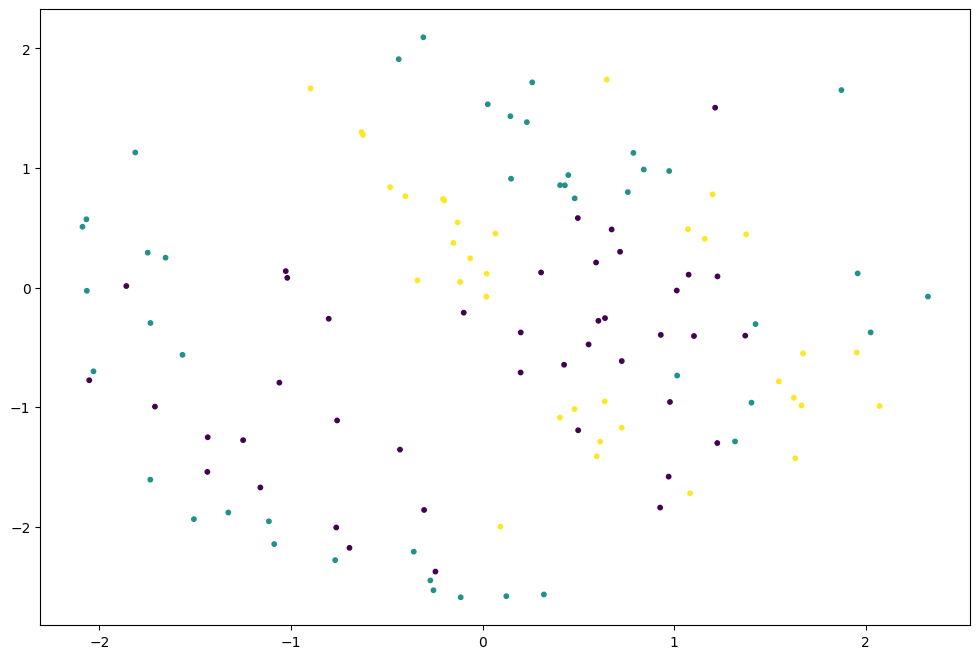

In [188]:
[y,E] = sammon(pd.DataFrame(weight_to_list(11,11,irish_jac)), 3,maxiter= 10000,init='random')


plt.figure(figsize=(12,8))
plt.scatter(y[:,0], y[:,1], s=10, c=c1, marker='o')

# ax = plt.axes(projection ="3d")
# ax.scatter3D(y[:,0], y[:,1],y[:,2], s=10, c=c1, marker='o')


## Diag data

In [49]:
#read diagnosis data
df_diag = pd.read_csv('D:\STATS4T06\Datasets\diagnosis.csv')


scaler = MinMaxScaler()
df_diag['Column1'] = scaler.fit_transform(df_diag[['Column1']])


trainx_diag = df_diag.iloc[:,0:6]

trainy1_diag = df_diag.loc[:,'Column7']
trainy1_diag = trainy1_diag.map({'yes': 1, 'no': 0})

trainy2_diag = df_diag.loc[:,'Column8']
trainy2_diag = trainy2_diag.map({'yes': 1, 'no': 0})

trainx_diag


,Column1,Column2,Column3,Column4,Column5,Column6
0,0.000000,no,yes,no,no,no
1,0.066667,no,no,yes,yes,yes
2,0.066667,no,yes,no,no,no
3,0.083333,no,no,yes,yes,yes
4,0.083333,no,yes,no,no,no
...,...,...,...,...,...,...
115,0.983333,no,yes,yes,no,yes
116,1.000000,no,no,no,no,no
117,1.000000,yes,yes,no,yes,no
118,1.000000,no,yes,yes,no,yes


In [117]:
diag_x = 10
diag_y = 10

diag_map,diag_re,diag_weights,diag_dis,diag_mse,diag_jac = train_fmsom(x=diag_x,y=diag_y,data=trainx_diag,y_label=trainy1_diag ,cr=1,s1=3,T=10,nei_fun = None,iteration=1000,seed = 1000)

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current interation is 13


In [ ]:
u = umatix_jac(10,10,diag_jac,1)
title = ('Iteration ' + str(60))

plt.imshow(u, cmap='bone_r')
plt.colorbar()
plt.title(title)
plt.show()



In [ ]:
title = ('Majority voting map after iteration ' + str(58))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(diag_map, cmap=cmap1)
cbar = plt.colorbar(heatmap, ticks=np.arange(-2/3, 4/3,2/3))
cbar.ax.set_yticklabels(['UND', '0', '1'])
#plt.colorbar(ticks=range(-1,1), label='digit value')


plt.show()

In [ ]:
df_diag_prot_mat = weightToProt_mat(9,9,1,diag_weights)
u = umatix(9,9,df_diag_prot_mat,trainx_diag,1)
plt.style.use('default')
#title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(u, cmap='bone_r')
plt.colorbar()
#plt.title(title)
plt.show()

In [ ]:
df_neuron_diag = pd.DataFrame(columns=['a1','a2','a3','a4','a5','a6'])
for i in range(8):
    for j in range(8):
        df_neuron_diag.loc[len(df_neuron_diag)] = df_diag_prot_mat[i][j]
print(df_neuron_diag)

df_neuron_diag.to_csv('df_neuron_diag.csv')

print(df_neuron_diag)

In [ ]:
df_diag_prot_mat = weightToProt_mat(10,10,1,diag_weights)
u = umatix(10,10,df_diag_prot_mat,trainx_diag,1)
plt.style.use('default')
#title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(u, cmap='bone_r')
plt.colorbar()
#plt.title(title)
plt.show()

In [659]:
test_kmeans(20, trainy1_diag, diag_re, diag_weights,2,1,10,10,seed = 151214099)

([0.65375, 0.07511449593786809], [0.11039330894747926, 0.09778899797761086])

In [650]:
test_kmeans_rmund(20, trainy1_diag, diag_re, diag_map, diag_weights,2,1,10,10,seed = 112141)

([0.7695833333333334, 0.0968702955846975],
 [0.3228942316647315, 0.221500327805124])

In [661]:
test_kmedios(10, trainy1_diag, diag_re, diag_map, diag_weights,2,1,10,10,seed = 112141)

([0.8333333333333334, 0.0], [0.4397389403172098, 0.0])

In [667]:
test_kmedios_rmund(10, trainy1_diag, diag_re, diag_map, diag_weights,2,1,10,10,seed = 112141)

([0.8333333333333334, 0.0], [0.4397389403172098, 0.0])

In [665]:
#diag_jac_l,diag_jac_lm = clusterMap_kmed(diag_weights,2,1,10,10,seed = 11289999)
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
#clusterMap_kmed_rmund(weights,map,k,cr,x,y,seed = 1000)
diag_jac_l,diag_jac_lm = clusterMap_kmed_rmund(diag_weights,diag_map,2,1,10,10,seed =699865)
diag_jac_assign = assign_jac(diag_re,diag_jac_lm)


# print(accuracy_score(list(diag_jac_assign.cluster), list(reverse_order(trainy1_diag))))
# print(adjusted_rand_score(list(diag_jac_assign.cluster), list(reverse_order(trainy1_diag))))

print(accuracy_score(list(diag_jac_assign.cluster), list(trainy1_diag)))
print(adjusted_rand_score(list(diag_jac_assign.cluster), list(trainy1_diag)))

print(pd.crosstab(diag_jac_assign.cluster, trainy1_diag, rownames=['Actual'], colnames=['Predicted']))

0.8333333333333334
0.4397389403172098
Predicted   0   1
Actual           
0          51  10
1          10  49


In [638]:
km_rmund_acc = [0.9166,0.74, 0.741,0.74166,0.7416,0.7416,0.7416,0.9166,0.7416,0.9166]
km_rmund_ari = [0.691,0.227, 0.227,0.22729,0.2272,0.227,0.227,0.691,0.227,0.691]

km_acc = [0.7416]
km_ari = []

## Irish

In [50]:
df_irish = pd.read_csv('D:\\STATS4T06\\Datasets\\irish.csv')

trainx_irish = df_irish.iloc[:,1:6]

scaler = MinMaxScaler()
trainx_irish['DVRT'] = scaler.fit_transform(trainx_irish[['DVRT']])
trainx_irish['Prestige_score'] = scaler.fit_transform(trainx_irish[['Prestige_score']])



trainy_irish = df_irish.iloc[:,6]

trainy_irish
trainy_irish = trainy_irish.map({'taken': 1, 'not_taken': 0})


trainx_irish.Type_school.unique()

#scaler.fit_transform(trainx_irish[['DVRT']])
trainx_irish

,DVRT,Prestige_score,Sex,Educational_level,Type_school
0,0.640000,0.175439,male,Junior_cycle_incomplete-secondary_school,secondary
1,0.480000,0.175439,male,Primary_terminal_leaver,primary_terminal_leaver
2,0.600000,0.894737,male,Senior_cycle_terminal_leaver-secondary_school,secondary
3,0.746667,0.684211,male,Junior_cycle_terminal_leaver-secondary_school,secondary
4,0.226667,0.000000,male,Junior_cycle_terminal_leaver-vocational_school,vocational
...,...,...,...,...,...
463,0.880000,0.210526,male,Senior_cycle_terminal_leaver-secondary_school,secondary
464,0.960000,0.771930,male,3rd_level_complete,secondary
465,0.946667,0.000000,male,3rd_level_complete,secondary
466,0.893333,0.333333,male,3rd_level_complete,secondary


In [426]:
irish_x = 11
irish_y = 11

#7, 25
#7, 10
# 7 50
irish_map,irish_re,irish_weights,irish_dis,irish_mse,irish_jac  = train_fmsom(x=irish_x,y=irish_y,data=trainx_irish,y_label=trainy_irish ,cr=2,s1=5,T=25,nei_fun = None,iteration=1000,seed = 10)

irish_mse

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

12.94592695163391

In [574]:
irish_jac_l,irish_jac_lm = clusterMap_jac(irish_weights,2,2,11,11,seed = 12512151)

#irish_jac_l,irish_jac_lm = clusterMap_jac_rmund(irish_weights,irish_map,2,2,11,11,seed = 125150)
irish_jac_assign = assign_jac(irish_re,irish_jac_lm)

irish_jac_assign.cluster


pd.crosstab(irish_jac_assign.cluster, trainy_irish, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,101,204
1,156,7


In [668]:
test_kmeans(20, trainy_irish, irish_re, irish_weights,2,2,11,11,seed = 151214099)

([0.7377136752136753, 0.07882812836828554],
 [0.2488458904317022, 0.09436019268136212])

In [669]:
test_kmeans_rmund(20, trainy_irish, irish_re, irish_map, irish_weights,2,2,11,11,seed = 112141)


([0.6487179487179485, 0.12374617719674694],
 [0.14763741732074184, 0.1414717233668747])

In [670]:
test_kmedios(10, trainy_irish, irish_re, irish_map, irish_weights,2,2,11,11,seed = 112141)

([0.5076923076923077, 0.01175019408963037],
 [-0.001346270726761392, 0.0012153144943486671])

In [671]:
test_kmedios_rmund(10, trainy_irish, irish_re, irish_map, irish_weights,2,2,11,11,seed = 112141)

([0.5, 0.0], [-0.002141880821551356, 0.0])

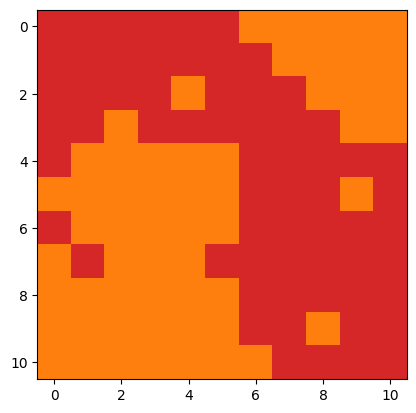

In [169]:
cmap1 = colors.ListedColormap(['tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(irish_jac_lm, cmap=cmap1)


    
plt.show()

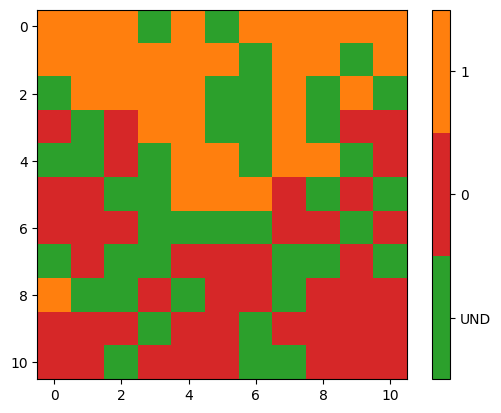

In [170]:
title = ('Majority voting map after iteration ' + str(58))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(irish_map, cmap=cmap1)
cbar = plt.colorbar(heatmap, ticks=np.arange(-2/3, 4/3,2/3))
cbar.ax.set_yticklabels(['UND', '0', '1'])
#plt.colorbar(ticks=range(-1,1), label='digit value')


plt.show()

In [194]:
df_ca = pd.read_csv("D:\\STATS4T06\\Datasets\\crx.data", delimiter=",",header=None)

print(df_ca)
df_ca.columns = ['a0', 'a1', 'a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15']

df_ca = df_ca.replace("?", np.nan)
df_ca = df_ca.dropna()



df_ca = df_ca.iloc[:,[1,2,7,10,13,14,3,4,5,6,8,9,11,12,15]]
df_ca = df_ca.reset_index()

df_ca['a1'] = df_ca['a1'].astype(float)
df_ca['a2'] = df_ca['a2'].astype(float)
df_ca['a7'] = df_ca['a7'].astype(float)
df_ca['a10'] = df_ca['a10'].astype(float)
df_ca['a13'] = df_ca['a13'].astype(float)
df_ca['a14'] = df_ca['a14'].astype(float)

scaler = MinMaxScaler()
df_ca['a1'] = scaler.fit_transform(df_ca[['a1']])
df_ca['a2'] = scaler.fit_transform(df_ca[['a2']])
df_ca['a7'] = scaler.fit_transform(df_ca[['a7']])
df_ca['a10'] = scaler.fit_transform(df_ca[['a10']])
df_ca['a13'] = scaler.fit_transform(df_ca[['a13']])
df_ca['a14'] = scaler.fit_transform(df_ca[['a14']])



trainx_ca = df_ca.iloc[:,1:14]


trainy_ca = df_ca.iloc[:,15].map({'+': 1, '-': 0})



    0      1       2  3  4   5   6     7  8  9   10 11 12     13   14 15
0    b  30.83   0.000  u  g   w   v  1.25  t  t   1  f  g  00202    0  +
1    a  58.67   4.460  u  g   q   h  3.04  t  t   6  f  g  00043  560  +
2    a  24.50   0.500  u  g   q   h  1.50  t  f   0  f  g  00280  824  +
3    b  27.83   1.540  u  g   w   v  3.75  t  t   5  t  g  00100    3  +
4    b  20.17   5.625  u  g   w   v  1.71  t  f   0  f  s  00120    0  +
..  ..    ...     ... .. ..  ..  ..   ... .. ..  .. .. ..    ...  ... ..
685  b  21.08  10.085  y  p   e   h  1.25  f  f   0  f  g  00260    0  -
686  a  22.67   0.750  u  g   c   v  2.00  f  t   2  t  g  00200  394  -
687  a  25.25  13.500  y  p  ff  ff  2.00  f  t   1  t  g  00200    1  -
688  b  17.92   0.205  u  g  aa   v  0.04  f  f   0  f  g  00280  750  -
689  b  35.00   3.375  u  g   c   h  8.29  f  f   0  t  g  00000    0  -

[690 rows x 16 columns]


In [350]:
ca_x = 10
ca_y = 10

# 12*12 s1 = 5 T = 10  mse:301.9397  cv: 0.470903 图一般
# 12*12 s1 = 5 T = 25  mse:301.4184  cv: 0.470618 图一般
# 12*12 s1 = 5 T = 50  mse:333.1652  cv: 0.49916  图一般好一点？
# 12*12 s1 = 6 T = 10  mse:262.7263  cv: 0.47433  图一般不是很好
# 12*12 s1 = 6 T = 25  mse:283.1454  cv: 0.47207  图一般不是很好 
# 12*12 s1 = 6 T = 50  mse:280.403   cv: 0.45935  图一般不是很好
# 12*12 s1 = 7 T = 10  mse:255.022   cv: 0.4233   图还行
# 12*12 s1 = 7 T = 25  mse:281.8884   cv: 0.48146   图一般
# 12*12 s1 = 7 T = 50  mse:289.9499   cv: 0.47667   图还行右上角有一点
ca_map1,ca_re1,ca_weights1,ca_dis1,ca_mse1,ca_jac  = train_fmsom(x=ca_x,y=ca_y,data=trainx_ca,y_label=trainy_ca ,cr=6,s1=5,T=25
                                                          ,nei_fun = None,iteration=10000,seed = 132)

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current interation is 39


In [582]:
# 10  5  25   seed = 12990323
ca_jac_l,ca_jac_lm = clusterMap_kmed(ca_weights1,2,6,10,10,seed = 10121231212)          

ca_jac_assign = assign_jac(ca_re1,ca_jac_lm)

ca_jac_assign.cluster


pd.crosstab(ca_jac_assign.cluster, trainy_ca, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,288,234
1,69,62


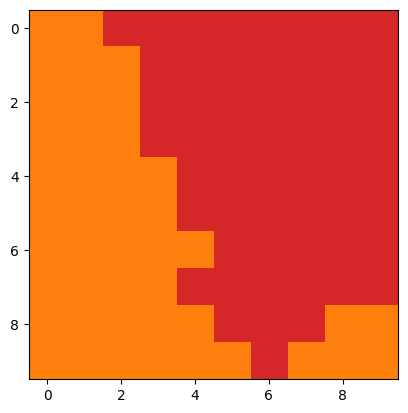

In [204]:
cmap1 = colors.ListedColormap(['tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(ca_jac_lm, cmap=cmap1)


    
plt.show()

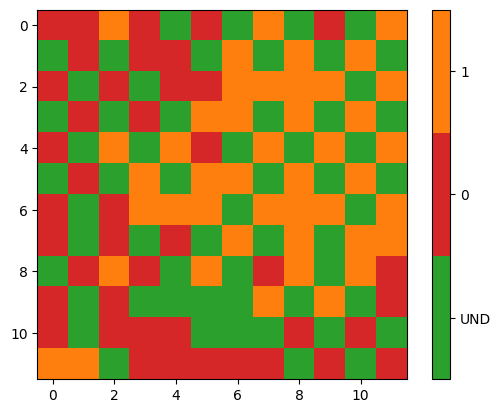

In [349]:
title = ('Majority voting map after iteration ' + str(58))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(ca_map1, cmap=cmap1)
cbar = plt.colorbar(heatmap, ticks=np.arange(-2/3, 4/3,2/3))
cbar.ax.set_yticklabels(['UND', '0', '1'])
#plt.colorbar(ticks=range(-1,1), label='digit value')


plt.show()

## Heart diease

In [51]:
df_heart = pd.read_csv('D:\\STATS4T06\\Datasets\\heartdf.csv')

trainx_heart = df_heart.iloc[:,1:14]

scaler = MinMaxScaler()
trainx_heart['age'] = scaler.fit_transform(trainx_heart[['age']])
trainx_heart['trestbps'] = scaler.fit_transform(trainx_heart[['trestbps']])
trainx_heart['chol'] = scaler.fit_transform(trainx_heart[['chol']])
trainx_heart['thalach'] = scaler.fit_transform(trainx_heart[['thalach']])
trainx_heart['oldpeak'] = scaler.fit_transform(trainx_heart[['oldpeak']])

trainy_heart = df_heart.iloc[:,14]


trainx_heart

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
0,0.479167,0.292453,0.196347,0.740458,0.161290,1,0,0,1,0,2,2,3
1,0.500000,0.433962,0.175799,0.641221,0.500000,1,0,1,0,1,0,0,3
2,0.854167,0.481132,0.109589,0.412214,0.419355,1,0,0,1,1,0,0,3
3,0.666667,0.509434,0.175799,0.687023,0.000000,1,0,0,1,0,2,1,3
4,0.687500,0.415094,0.383562,0.267176,0.306452,0,0,1,1,0,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.625000,0.433962,0.216895,0.709924,0.000000,1,1,0,1,1,2,0,2
1021,0.645833,0.292453,0.301370,0.534351,0.451613,1,0,0,0,1,1,1,3
1022,0.375000,0.150943,0.340183,0.358779,0.161290,1,0,0,0,1,1,1,2
1023,0.437500,0.150943,0.292237,0.671756,0.000000,0,0,0,0,0,2,0,2


In [475]:
heart_x = 12
heart_y = 12

heart_map,heart_re,heart_weights,heart_dis,heart_mse,heart_jac  = train_fmsom(x=heart_x,y=heart_y,data=trainx_heart,y_label=trainy_heart ,cr=5,s1=7,T=25,nei_fun = None,iteration=1000,seed = 10)


current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

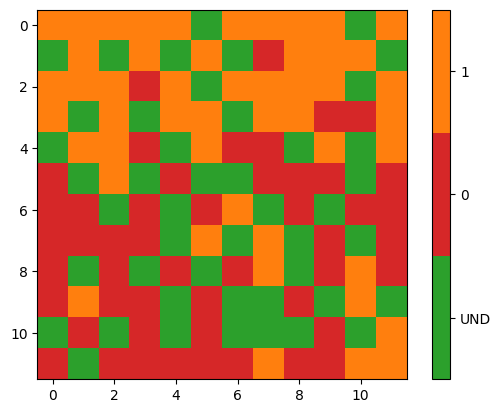

In [476]:
title = ('Majority voting map after iteration ' + str(58))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(heart_map, cmap=cmap1)
cbar = plt.colorbar(heatmap, ticks=np.arange(-2/3, 4/3,2/3))
cbar.ax.set_yticklabels(['UND', '0', '1'])
#plt.colorbar(ticks=range(-1,1), label='digit value')


plt.show()

In [571]:
#heart_jac_l,heart_jac_lm = clusterMap_jac(heart_jac,2,5,20,20,seed = 1994131111)

# heart_jac_l,heart_jac_lm = clusterMap_jac(heart_jac,2,5,20,20,seed = 111183211111)
heart_jac_l,heart_jac_lm = clusterMap_jac(heart_weights,2,5,12,12,seed = 11221121)   #稳定

#heart_jac_l,heart_jac_lm = clusterMap_jac_rmund(heart_weights,heart_map,2,5,12,12,seed = 1011413200)
heart_jac_assign = assign_jac(heart_re,heart_jac_lm)


pd.crosstab(heart_jac_assign.cluster, trainy_heart, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,91,415
1,408,111


In [672]:
test_kmeans(10, trainy_heart, heart_re, heart_weights,2,5,12,12,seed = 151214099)

([0.8092682926829269, 0.003834779318445555],
 [0.38204329142554017, 0.009412062380313833])

In [673]:
test_kmeans_rmund(10, trainy_heart, heart_re, heart_map, heart_weights,2,5,12,12,seed = 112141)


([0.7890731707317074, 0.05524880719087317],
 [0.3458286286354554, 0.09536355775116205])

In [674]:
test_kmedios(10, trainy_heart, heart_re, heart_map, heart_weights,2,5,12,12,seed = 112141)


([0.7006829268292682, 0.07421537223050435],
 [0.1823534337414439, 0.09997843131796397])

In [675]:
test_kmedios_rmund(10, trainy_heart, heart_re, heart_map, heart_weights,2,5,12,12,seed = 112141)

([0.7006829268292682, 0.07421537223050435],
 [0.1823534337414439, 0.09997843131796397])

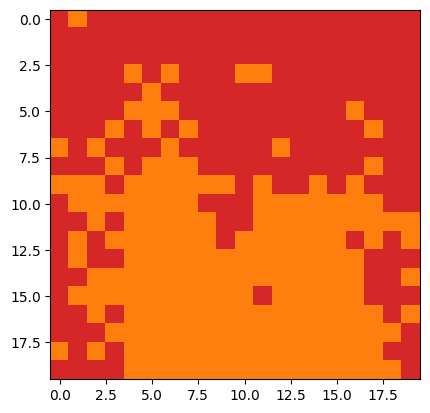

In [309]:
cmap1 = colors.ListedColormap(['tab:red', 'tab:orange'])

plt.style.use('default')
heatmap = plt.imshow(heart_jac_lm, cmap=cmap1)


    
plt.show()

In [323]:
#randCenter_jac_plus(weights_list,k,cr,seed)


# weight_to_list(20,20,heart_jac)



def randCenter_jac_plus1(weights_list,k,cr,seed):

    random.seed(seed)

    ww = list(enumerate(weights_list))

    
    centers = random.sample(ww, 1)

    selected_indices = [t[0] for t in centers]

    ind = []
    ind.append(selected_indices)

    for i in range(k-1):

        ref_center = centers[i][1]
        #print(ref_center)
        maxDis = 0
        maxCenter = None
        maxIndex = -1
        
        for j in range(len(weights_list)):
            if disBetTwo_jaccard(ref_center, weights_list[j], cr) > maxDis:
                maxCenter = weights_list[j]
                maxIndex = j
            
        centers.append(maxCenter)
        ind.append(maxIndex)
    return ind




[[125], 399]

In [325]:
print(randCenter_jac_plus1(weight_to_list(20,20,heart_jac),2,5,199412231111))
print(randCenter_jac_plus(weight_to_list(20,20,heart_jac),2,5,199412231111))

[[125], 399]
[[0.29166666666666663, 0.15094339622641517, 0.19406392694063926, 0.6870229007633587, 0.0, {1: 1.8242897085076644, 0: 0}, {0: 1.8242897085076644, 1: 0, 2: 0, 3: 0}, {0: 1.8242897085076644, 1: 0}, {1: 1.8242897085076644, 0: 0, 2: 0}, {0: 1.8242897085076644, 1: 0}, {2: 1.8242897085076644, 0: 0, 1: 0}, {2: 0, 0: 1.8242897085076644, 1: 0, 3: 0, 4: 0}, {3: 1.8242897085076644, 2: 0, 1: 0, 0: 0}], [0.6513900135796604, 0.3874477428141882, 0.2957586872133857, 0.5889537514079521, 0.14858724474422322, {1: 10.689062264528104, 0: 0}, {0: 4.0, 1: 0, 2: 2.432386278010219, 3: 4.256675986517883}, {0: 0, 1: 10.689062264528104}, {1: 0, 0: 10.689062264528104, 2: 0}, {0: 4.256675986517883, 1: 6.4323862780102194}, {2: 0, 0: 0, 1: 10.689062264528104}, {2: 0, 0: 0, 1: 10.689062264528104, 3: 0, 4: 0}, {3: 0, 2: 8.256675986517886, 1: 2.432386278010219, 0: 0}]]


In [326]:
print(randCenter_jac_plus1(weight_to_list(20,20,heart_jac),2,5,1994131111))
print(randCenter_jac_plus(weight_to_list(20,20,heart_jac),2,5,1994131111))

[[144], 399]
[[0.6354166666666666, 0.2830188679245284, 0.2111872146118721, 0.6679389312977099, 0.008064516129032258, {1: 8.0, 0: 0}, {0: 8.0, 1: 0, 2: 0, 3: 0}, {0: 8.0, 1: 0}, {1: 8.0, 0: 0, 2: 0}, {0: 8.0, 1: 0}, {2: 8.0, 0: 0, 1: 0}, {2: 0, 0: 0, 1: 8.0, 3: 0, 4: 0}, {3: 8.0, 2: 0, 1: 0, 0: 0}], [0.6513900135796604, 0.3874477428141882, 0.2957586872133857, 0.5889537514079521, 0.14858724474422322, {1: 10.689062264528104, 0: 0}, {0: 4.0, 1: 0, 2: 2.432386278010219, 3: 4.256675986517883}, {0: 0, 1: 10.689062264528104}, {1: 0, 0: 10.689062264528104, 2: 0}, {0: 4.256675986517883, 1: 6.4323862780102194}, {2: 0, 0: 0, 1: 10.689062264528104}, {2: 0, 0: 0, 1: 10.689062264528104, 3: 0, 4: 0}, {3: 0, 2: 8.256675986517886, 1: 2.432386278010219, 0: 0}]]


## Credit Approval

In [71]:

df_ca = pd.read_csv("D:\\STATS4T06\\Datasets\\crx.data", delimiter=",",header=None)

df_ca.columns = ['a0', 'a1', 'a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15']

df_ca = df_ca.replace("?", np.nan)
df_ca = df_ca.dropna()



df_ca = df_ca.iloc[:,[1,2,7,10,13,14,3,4,5,6,8,9,11,12,15]]
df_ca = df_ca.reset_index()

df_ca['a1'] = df_ca['a1'].astype(float)
df_ca['a2'] = df_ca['a2'].astype(float)
df_ca['a7'] = df_ca['a7'].astype(float)
df_ca['a10'] = df_ca['a10'].astype(float)
df_ca['a13'] = df_ca['a13'].astype(float)
df_ca['a14'] = df_ca['a14'].astype(float)

scaler = MinMaxScaler()
df_ca['a1'] = scaler.fit_transform(df_ca[['a1']])
df_ca['a2'] = scaler.fit_transform(df_ca[['a2']])
df_ca['a7'] = scaler.fit_transform(df_ca[['a7']])
df_ca['a10'] = scaler.fit_transform(df_ca[['a10']])
df_ca['a13'] = scaler.fit_transform(df_ca[['a13']])
df_ca['a14'] = scaler.fit_transform(df_ca[['a14']])



trainx_ca = df_ca.iloc[:,1:14]


trainy_ca = df_ca.iloc[:,15].map({'+': 1, '-': 0})
trainx_ca


,a1,a2,a7,a10,a13,a14,a3,a4,a5,a6,a8,a9,a11
0,0.271111,0.000000,0.043860,0.014925,0.1010,0.00000,u,g,w,v,t,t,f
1,0.713016,0.159286,0.106667,0.089552,0.0215,0.00560,u,g,q,h,t,t,f
2,0.170635,0.017857,0.052632,0.000000,0.1400,0.00824,u,g,q,h,t,f,f
3,0.223492,0.055000,0.131579,0.074627,0.0500,0.00003,u,g,w,v,t,t,t
4,0.101905,0.200893,0.060000,0.000000,0.0600,0.00000,u,g,w,v,t,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,0.116349,0.360179,0.043860,0.000000,0.1300,0.00000,y,p,e,h,f,f,f
649,0.141587,0.026786,0.070175,0.029851,0.1000,0.00394,u,g,c,v,f,t,t
650,0.182540,0.482143,0.070175,0.014925,0.1000,0.00001,y,p,ff,ff,f,t,t
651,0.066190,0.007321,0.001404,0.000000,0.1400,0.00750,u,g,aa,v,f,f,f


In [97]:
ca_x = 15
ca_y = 15

ca_map,ca_re,ca_weights,ca_dis,ca_mse,ca_jac  = train_fmsom(x=ca_x,y=ca_y,data=trainx_ca,y_label=trainy_ca ,cr=6,s1=7,T=10
                                                          ,nei_fun = None,iteration=1000,seed = 13992)


current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current interation is 24


In [98]:
credit_jac_l,credit_jac_lm = clusterMap_jac(ca_weights,2,6,15,15,seed = 112199121)   #稳定

#heart_jac_l,heart_jac_lm = clusterMap_jac_rmund(heart_weights,heart_map,2,5,12,12,seed = 1011413200)
credit_jac_assign = assign_jac(ca_re,credit_jac_lm)


pd.crosstab(credit_jac_assign.cluster, trainy_ca, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,169,257
1,188,39


In [79]:
test_kmedios(10, trainy_ca, ca_re, ca_map, ca_weights,2,6,15,15,seed = 112141)

([0.5635528330781011, 0.0], [0.008309507205449453, 1.734723475976807e-18])

In [99]:
test_kmeans(10, trainy_ca, ca_re, ca_weights,2,6,15,15,seed = 112141)

([0.6535987748851454, 0.11943063435877763],
 [0.148988379766145, 0.1792469216992681])

## K-prototype

In [16]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import accuracy_score

In [39]:
kproto = KPrototypes(n_clusters=2, verbose=0)
clusters_diag = kproto.fit_predict(trainx_diag, categorical=[1,2,3,4,5])
accuracy_score(clusters_diag, trainy1_diag)
print(adjusted_rand_score(clusters_diag, trainy1_diag))

-0.0052098941884321905


In [40]:

clusters_irish = kproto.fit_predict(trainx_irish, categorical=[2,3,4])
print(accuracy_score(clusters_irish, reverse_order(trainy_irish)))
print(adjusted_rand_score(clusters_irish, reverse_order(trainy_irish)))

0.782051282051282
0.3163883685959149


In [36]:

clusters_heart = kproto.fit_predict(trainx_heart, categorical=[5,6,7,8,9,10,11,12])
print(accuracy_score(clusters_heart, reverse_order(trainy_heart)))
print(adjusted_rand_score(clusters_heart, reverse_order(trainy_heart)))

0.8204878048780487
0.410277651774269


In [81]:
clusters_ca = kproto.fit_predict(trainx_ca, categorical=[6,7,8,9,10,11,12])
print(accuracy_score(clusters_ca,trainy_ca))
print(adjusted_rand_score(clusters_ca, trainy_ca))

0.8070444104134763
0.3761352325606098
